In [67]:
from datetime import datetime
from pathlib import Path
import json
import os
from pathlib import Path

import crowsetta
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
from tqdm import tqdm
import torch.utils.data

import vak
from vak import (
    config,
    constants,
    core,
    files,
    io,
    labeled_timebins,
    logging,
)
from vak.logging import log_or_print
from vak import models
from vak import transforms
from vak.datasets import VocalDataset
from vak.device import get_default as get_default_device

In [2]:
def predict_core(
    csv_path,
    checkpoint_path,
    labelmap_path,
    model_config_map,
    window_size,
    num_workers=2,
    spect_key="s",
    timebins_key="t",
    spect_scaler_path=None,
    device=None,
    annot_csv_filename=None,
    min_segment_dur=None,
    majority_vote=False,
    save_net_outputs=False,
    logger=None,
):
    """make predictions on dataset with trained model specified in config.toml file.

    copied/adapted from `vak` -- returns predictions instead of saving them.
    
    Returns
    -------
    None
    """
    if device is None:
        device = get_default_device()

    # ---------------- load data for prediction ------------------------------------------------------------------------
    if spect_scaler_path:
        log_or_print(
            f"loading SpectScaler from path: {spect_scaler_path}",
            logger=logger,
            level="info",
        )
        spect_standardizer = joblib.load(spect_scaler_path)
    else:
        log_or_print(
            f"Not loading SpectScaler, no path was specified",
            logger=logger,
            level="info",
        )
        spect_standardizer = None

    item_transform = transforms.get_defaults(
        "predict",
        spect_standardizer,
        window_size=window_size,
        return_padding_mask=True,
    )

    log_or_print(
        f"loading labelmap from path: {labelmap_path}", logger=logger, level="info"
    )
    with labelmap_path.open("r") as f:
        labelmap = json.load(f)

    log_or_print(
        f"loading dataset to predict from csv path: {csv_path}",
        logger=logger,
        level="info",
    )
    pred_dataset = VocalDataset.from_csv(
        csv_path=csv_path,
        split="predict",
        labelmap=labelmap,
        spect_key=spect_key,
        timebins_key=timebins_key,
        item_transform=item_transform,
    )

    pred_data = torch.utils.data.DataLoader(
        dataset=pred_dataset,
        shuffle=False,
        # batch size 1 because each spectrogram reshaped into a batch of windows
        batch_size=1,
        num_workers=num_workers,
    )

    # ---------------- set up to convert predictions to annotation files -----------------------------------------------
    if annot_csv_filename is None:
        annot_csv_filename = Path(csv_path).stem + constants.ANNOT_CSV_SUFFIX
    annot_csv_path = Path('.') / 'dummy-filename.csv'  # not really used
    log_or_print(
        f"will save annotations in .csv file: {annot_csv_path}",
        logger=logger,
        level="info",
    )

    dataset_df = pd.read_csv(csv_path)
    timebin_dur = io.dataframe.validate_and_get_timebin_dur(dataset_df)
    log_or_print(
        f"dataset has timebins with duration: {timebin_dur}",
        logger=logger,
        level="info",
    )

    # ---------------- do the actual predicting + converting to annotations --------------------------------------------
    input_shape = pred_dataset.shape
    # if dataset returns spectrogram reshaped into windows,
    # throw out the window dimension; just want to tell network (channels, height, width) shape
    if len(input_shape) == 4:
        input_shape = input_shape[1:]
    log_or_print(
        f"shape of input to networks used for predictions: {input_shape}",
        logger=logger,
        level="info",
    )

    log_or_print(
        f"instantiating models from model-config map:/n{model_config_map}",
        logger=logger,
        level="info",
    )
    models_map = models.from_model_config_map(
        model_config_map, num_classes=len(labelmap), input_shape=input_shape
    )
    for model_name, model in models_map.items():
        # ---------------- do the actual predicting --------------------------------------------------------------------
        log_or_print(
            f"loading checkpoint for {model_name} from path: {checkpoint_path}",
            logger=logger,
            level="info",
        )
        model.load(checkpoint_path, device=device)
        log_or_print(
            f"running predict method of {model_name}", logger=logger, level="info"
        )
        pred_dict = model.predict(pred_data=pred_data, device=device)

        # ----------------  converting to annotations ------------------------------------------------------------------
        progress_bar = tqdm(pred_data)

        annots = []
        log_or_print(
            "converting predictions to annotations", logger=logger, level="info"
        )
        for ind, batch in enumerate(progress_bar):
            padding_mask, spect_path = batch["padding_mask"], batch["spect_path"]
            padding_mask = np.squeeze(padding_mask)
            if isinstance(spect_path, list) and len(spect_path) == 1:
                spect_path = spect_path[0]
            y_pred = pred_dict[spect_path]

            y_pred = torch.argmax(y_pred, dim=1)  # assumes class dimension is 1
            y_pred = torch.flatten(y_pred).cpu().numpy()[padding_mask]

            spect_dict = files.spect.load(spect_path)
            t = spect_dict[timebins_key]
            labels, onsets_s, offsets_s = labeled_timebins.lbl_tb2segments(
                y_pred,
                labelmap=labelmap,
                t=t,
                min_segment_dur=min_segment_dur,
                majority_vote=majority_vote,
            )
            if labels is None and onsets_s is None and offsets_s is None:
                # handle the case when all time bins are predicted to be unlabeled
                # see https://github.com/NickleDave/vak/issues/383
                continue
            seq = crowsetta.Sequence.from_keyword(
                labels=labels, onsets_s=onsets_s, offsets_s=offsets_s
            )

            audio_fname = files.spect.find_audio_fname(spect_path)
            annot = crowsetta.Annotation(
                seq=seq, audio_path=audio_fname, annot_path=annot_csv_path.name
            )
            annots.append(annot)
        
    return pred_dict, annots

In [3]:
def predict_cli(toml_path):
    toml_path = Path(toml_path)
    cfg = config.parse.from_toml_path(toml_path)

    if cfg.predict is None:
        raise ValueError(
            f"predict called with a config.toml file that does not have a PREDICT section: {toml_path}"
        )

    # ---- set up logging ----------------------------------------------------------------------------------------------
    timenow = datetime.now().strftime("%y%m%d_%H%M%S")

    model_config_map = config.models.map_from_path(toml_path, cfg.predict.models)

    pred_dict, annots = predict_core(
        csv_path=cfg.predict.csv_path,
        checkpoint_path=cfg.predict.checkpoint_path,
        labelmap_path=cfg.predict.labelmap_path,
        model_config_map=model_config_map,
        window_size=cfg.dataloader.window_size,
        num_workers=cfg.predict.num_workers,
        spect_key=cfg.spect_params.spect_key,
        timebins_key=cfg.spect_params.timebins_key,
        spect_scaler_path=cfg.predict.spect_scaler_path,
        device=cfg.predict.device,
        annot_csv_filename=cfg.predict.annot_csv_filename,
        min_segment_dur=cfg.predict.min_segment_dur,
        majority_vote=cfg.predict.majority_vote,
        save_net_outputs=cfg.predict.save_net_outputs,
        logger=None,
    )

    return pred_dict, annots

In [63]:
def plot_segments(
    annot,
    label_color_map,
    t,
    tlim=None,
    y_segments=0.5,
    y_labels=0.6,
    line_kwargs=None,
    text_kwargs=None,
    ax=None,
):
    """plot segments as colored rectangles

    Parameters
    ----------
    annot : crowsetta.Annotation
        annotation that has segments to be plotted
        (the `annot.seq.segments` attribute)
    t : numpy.ndarray
        vector of centers of time bins from spectrogram
    tlim : tuple, list
        limits of time axis (tmin, tmax) (i.e., x-axis).
        Default is None, in which case entire range of t will be plotted.
    y_segments : float
        height at which segments should be plotted.
        Default is 0.5 (assumes y-limits of 0 and 1).
    ax : matplotlib.axes.Axes
        axes on which to plot segments.
        Default is None, in which case
        a new figure with a single axes is created
    """
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_ylim(0, 1)

    for seg in annot.seq.segments:
        label, onset_s, offset_s = seg.label, seg.onset_s, seg.offset_s
        rectangle = plt.Rectangle(
            (onset_s, 0.1), 
            offset_s - onset_s,
            1.0,
            facecolor=label_color_map[label]
        )
        ax.add_patch(rectangle)

    if tlim:
        ax.set_xlim(tlim)
        tmin, tmax = tlim

In [82]:
def plot_spect_with_segments(
    s,
    t,
    f,
    annot,
    label_color_map,
    figsize = (10, 6),    
    tlim = [1.5, 3.0],
    flim=None,
):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3)
    spect_ax = fig.add_subplot(gs[:2, :])
    segment_ax = fig.add_subplot(gs[2, :])

    vak.plot.spect(s, t, f, tlim=tlim, flim=flim, ax=spect_ax)

    plot_segments(
        annot, label_color_map, t, tlim, ax=segment_ax
    )
    segment_ax.set_axis_off()

In [4]:
toml_path = '/home/bart/Documents/repos/coding/birdsong/tweetynet/article/data/configs/Canaries/llb3_predict_first_submission_longtrain.toml'

In [5]:
cd /home/bart/Documents/repos/coding/birdsong/tweetynet/article

/home/bart/Documents/repos/coding/birdsong/tweetynet/article


In [5]:
pred_dict, annots = predict_cli(toml_path)

Not loading SpectScaler, no path was specified
loading labelmap from path: /home/bart/Documents/repos/coding/birdsong/tweetynet/article/results/Canaries/long_train/long_train/llb3/results_210528_224118/labelmap.json
loading dataset to predict from csv path: /home/bart/Documents/repos/coding/birdsong/tweetynet/article/data/Canaries/promo-fig/annotated_prep_220131_114437.csv
will save annotations in .csv file: dummy-filename.csv
dataset has timebins with duration: 0.0027
shape of input to networks used for predictions: torch.Size([1, 513, 370])
instantiating models from model-config map:/n{'TweetyNet': {'optimizer': {'lr': 0.001}, 'network': {}, 'loss': {}, 'metrics': {}}}
loading checkpoint for TweetyNet from path: /home/bart/Documents/repos/coding/birdsong/tweetynet/article/results/Canaries/long_train/long_train/llb3/results_210528_224118/TweetyNet/checkpoints/max-val-acc-checkpoint.pt
Loading checkpoint from:
/home/bart/Documents/repos/coding/birdsong/tweetynet/article/results/Canarie

  0%|                                                                                                                               | 0/2655 [00:00<?, ?it/s]

converting predictions to annotations


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2655/2655 [02:38<00:00, 16.76it/s]


In [61]:
labelset = set(
    [segment.label for annot in annots for segment in annot.seq.segments]
)
palette = sns.color_palette("husl", len(labelset))
label_color_map = {label: color for label, color in zip(labelset, palette)}

In [80]:
# defined here so variables are in scope!

def spect_and_annot_from_vocal_num(
    vocal_num,
):
    spect_path = list(pred_dict.keys())[vocal_num]
    spect_dict = vak.files.spect.load(spect_path)
    s, t, f = spect_dict['s'], spect_dict['t'], spect_dict['f']

    annot = annots[vocal_num]
    
    return s, t, f, annot

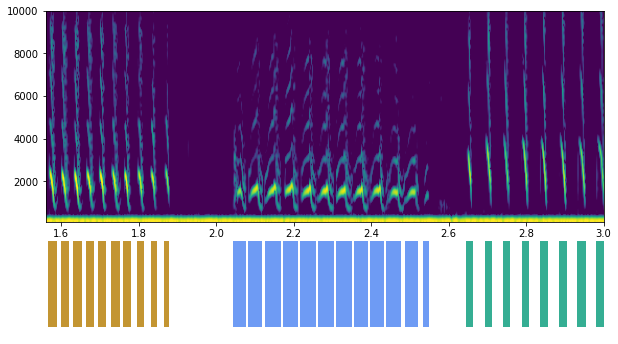

In [86]:
s, t, f, annot = spect_and_annot_from_vocal_num(
    vocal_num,
)

plot_spect_with_segments(
    s,
    t,
    f,
    annot,
    label_color_map,
    figsize = (10, 6),
    flim = [100, 10000],
    tlim = [1.56, 3.0],
)